In [166]:
import pandas as pd
import numpy as np
import re

from tqdm import tqdm
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

import statsmodels.api as sm

# 1. Volume Data

In [2]:
df_vol = pd.read_csv("../data/inbound_volume_data.csv", index_col=0)

In [3]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015/07,Provider_1,Plant_1,19096,20298
1,2015/08,Provider_1,Plant_1,187139,189973
2,2015/09,Provider_1,Plant_1,181149,187798
3,2015/10,Provider_1,Plant_1,202677,202327
4,2015/11,Provider_1,Plant_1,272902,271765


In [4]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Timestamp          47058 non-null  object
 1   Provider           47058 non-null  object
 2   Plant              47058 non-null  object
 3   Actual Vol [Kg]    47055 non-null  object
 4   Expected Vol [Kg]  46951 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [5]:
df_vol.shape

(47058, 5)

In [6]:
df_vol.describe()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
count,47058,47058,47058,47055,46951
unique,106,38,18,45291,46179
top,2018/08,Provider_3,Plant_19,160,0
freq,493,1779,2922,17,57


## 1.1 Convert Timestamp to datetime object 

In [7]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015/07,Provider_1,Plant_1,19096,20298
1,2015/08,Provider_1,Plant_1,187139,189973
2,2015/09,Provider_1,Plant_1,181149,187798
3,2015/10,Provider_1,Plant_1,202677,202327
4,2015/11,Provider_1,Plant_1,272902,271765


In [8]:
df_vol["Year"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_vol["Month"] = df_vol["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_vol["Timestamp"] = df_vol[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)

In [9]:
# Create Timeseries Key
df_vol["ts_key"] = df_vol[["Provider", "Plant"]].apply(
    lambda x: x["Provider"] + "-" + x["Plant"], axis=1
)

In [10]:
print("Unique Timeseries:", df_vol['ts_key'].nunique())

Unique Timeseries: 624


In [11]:
# Convert String values to float
# df_vol['Actual Vol [Kg]'] = df_vol['Actual Vol [Kg]'].astype('float32')
# df_vol['Expected Vol [Kg]'] = df_vol['Expected Vol [Kg]'].astype('float32')

However you will find the error `ValueError: could not convert string to float: '1.736.973'"`. That is due to the fact, the the column contains both String and Numeric values. Therefore we need to transform all non-numeric values to numeric. In most cases we would have to talk to the business area and verify how to interpret those "wrong" values. In this case, we just need to remove any (.) and replace it by and empty string. These are just thousands separators. On the other hand, the comma (,) is the decimal separator, we also need to replace those by dots (.). 

In [12]:
# We can verify by ourselves which datapoints contain
# (.) in the Column "Actual Vol [Kg]"
df_vol[
    df_vol["Actual Vol [Kg]"].apply(lambda x: True if "." in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
55308,2022-01-01,Provider_2,Plant_4,784.974,758.414,2022,1,Provider_2-Plant_4
55309,2022-01-01,Provider_3,Plant_4,1.736.973,1.544.132,2022,1,Provider_3-Plant_4
55310,2022-01-01,Provider_4,Plant_4,417.621,1.002.859,2022,1,Provider_4-Plant_4
55311,2022-01-01,Provider_5,Plant_4,2.535.036,2.699.221,2022,1,Provider_5-Plant_4
55312,2022-01-01,Provider_6,Plant_4,98.101,98.348,2022,1,Provider_6-Plant_4


In [13]:
# We can verify by ourselves which datapoints contain
# (.) in the Column "Expected Vol [Kg]"
df_vol[
    df_vol["Expected Vol [Kg]"].apply(lambda x: True if "." in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
11925,2016-10-01,Provider_16,Plant_1,1937,2.026,2016,10,Provider_16-Plant_1
11926,2016-11-01,Provider_16,Plant_1,159462,156.923,2016,11,Provider_16-Plant_1
11927,2016-12-01,Provider_16,Plant_1,371940,371.941,2016,12,Provider_16-Plant_1
11928,2017-01-01,Provider_16,Plant_1,409358,409.111,2017,1,Provider_16-Plant_1
11929,2017-02-01,Provider_16,Plant_1,347810,341.743,2017,2,Provider_16-Plant_1


In [14]:
# We can verify by ourselves which datapoints contain
# (,) in the Column "Actual Vol [Kg]"
df_vol[
    df_vol["Actual Vol [Kg]"].apply(lambda x: True if "," in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key


In [15]:
# We can verify by ourselves which datapoints contain
# (,) in the Column "Expected Vol [Kg]"
df_vol[
    df_vol["Expected Vol [Kg]"].apply(lambda x: True if "," in str(x) else False)
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key
108,2018-01-01,Provider_1,Plant_3,192728,"196852,881",2018,1,Provider_1-Plant_3
188,2017-11-01,Provider_1,Plant_5,115609,"82748,497",2017,11,Provider_1-Plant_5
231,2017-03-01,Provider_1,Plant_6,146423,"91172,432",2017,3,Provider_1-Plant_6
497,2017-08-01,Provider_1,Plant_12,526399,"518210,158",2017,8,Provider_1-Plant_12
531,2016-03-01,Provider_1,Plant_13,937039,"830825,712",2016,3,Provider_1-Plant_13


A more general way to find all non-numeric characters is using a regular expresion to retrieve all those values and verify if there are any edge cases. This is important since we could have other special character in between the numbers which will provoke a `ValueError` when trying to parse it to string. 

In [16]:
def non_numeric_characters(input_string: str) -> str:
    """
    Define a regular expression pattern
    to match any non-digit character
    """
    pattern = re.compile(r"\D")
    non_numeric_chars = pattern.findall(str(input_string))
    return str(non_numeric_chars)

In [17]:
# Find all non-numeric characters
df_vol["Actual Vol [Kg]"].dropna().apply(non_numeric_characters).unique()

# Expected output = array(['[]', "['.']", "['.', '.']"], dtype=object)

array(['[]', "['.']", "['.', '.']"], dtype=object)

As we can see, the only non-numeric character in the column "'Actual Vol [Kg]" is the (.). So there is no problem to replace it by an empty string. 

In [18]:
# Find all non-numeric characters
df_vol["Expected Vol [Kg]"].dropna().apply(non_numeric_characters).unique()

# Expected output = array(['[]', "[',']", "['.']", "['.', '.']"], dtype=object)

array(['[]', "[',']", "['.']", "['.', '.']"], dtype=object)

On the other hand, for the column "Expected Vol [Kg]", we see that we have both cases. We have to first replace (.) by empty string and then replace (,) by (.). Not the other way around. Now let's fix the two columns and parse them to float. We can also convert all the [Kg] to [Tons], so we have smaller number to work with.

In [19]:
df_vol["Actual Vol [Kg]"] = (
    df_vol["Actual Vol [Kg]"].str.replace(".", "").astype("float")
)
df_vol["Expected Vol [Kg]"] = df_vol["Expected Vol [Kg]"].str.replace(".", "")
df_vol["Expected Vol [Kg]"] = (
    df_vol["Expected Vol [Kg]"].str.replace(",", ".").astype("float")
)

df_vol["Actual Vol [Tons]"] = np.round(df_vol["Actual Vol [Kg]"] / 1000, 3)
df_vol["Expected Vol [Tons]"] = np.round(df_vol["Expected Vol [Kg]"] / 1000, 3)

In [20]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Timestamp            47058 non-null  datetime64[ns]
 1   Provider             47058 non-null  object        
 2   Plant                47058 non-null  object        
 3   Actual Vol [Kg]      47055 non-null  float64       
 4   Expected Vol [Kg]    46951 non-null  float64       
 5   Year                 47058 non-null  int64         
 6   Month                47058 non-null  int64         
 7   ts_key               47058 non-null  object        
 8   Actual Vol [Tons]    47055 non-null  float64       
 9   Expected Vol [Tons]  46951 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 3.9+ MB


In [21]:
df_vol.head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key,Actual Vol [Tons],Expected Vol [Tons]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,2015,7,Provider_1-Plant_1,19.096,20.298
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,2015,8,Provider_1-Plant_1,187.139,189.973
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,2015,9,Provider_1-Plant_1,181.149,187.798
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,2015,10,Provider_1-Plant_1,202.677,202.327
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,2015,11,Provider_1-Plant_1,272.902,271.765


## 1.2 Timeseries Plots

let's generate plot for the first Timeseries Key

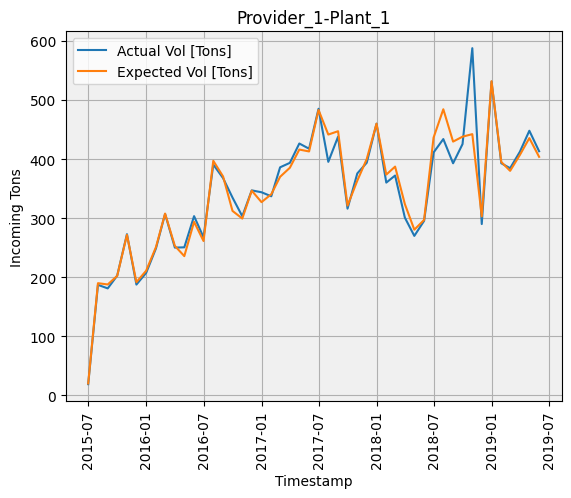

<Figure size 1200x500 with 0 Axes>

In [22]:
ts_key = "Provider_1-Plant_1"
x_axis = "Timestamp"
y1_axis = "Actual Vol [Tons]"
y2_axis = "Expected Vol [Tons]"
_df = df_vol.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]

# Create a figure
fig, ax = plt.subplots()

# Create a line plot
plt.rc("text", usetex=False)
plt.figure(figsize=(12, 5))
ax.plot(x, y1, label=y1_axis)
ax.plot(x, y2, label=y2_axis)

# Add gridlines
ax.grid(True)

# Set a light gray background color
ax.set_facecolor("#f0f0f0")

# Add labels and a legend
ax.set_xlabel(x_axis)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Incoming Tons")
ax.set_title(ts_key)
ax.legend()

# # Show the plot
plt.show()

Now let's crate a plot per timeseries and store it as a PDF. This will allows us to spot patterns, outliers and also to have an easier tool to communicate with the business team.

In [159]:
# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages("Timeseries_Tons.pdf") as pdf:
    # ts_key = 'Provider_1-Plant_1'
    x_axis = "Timestamp"
    y1_axis = "Actual Vol [Tons]"
    y2_axis = "Expected Vol [Tons]"

    for ts_key in tqdm(df_vol["ts_key"].unique()):
        _df = df_vol.query(f" ts_key == '{ts_key}'")
        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]

        # Turn off interactive mode
        plt.ioff()

        # Activate autolayout so
        # that the whole plot fits into one page
        plt.rcParams["figure.autolayout"] = True

        # Create a figure
        fig, ax = plt.subplots()

        # Create a line plot
        plt.rc("text", usetex=False)
        plt.figure(figsize=(12, 5))

        ax.plot(x, y1, label=y1_axis)
        ax.plot(x, y2, label=y2_axis)
        ax.grid(True)
        ax.set_facecolor("#f0f0f0")

        # Add labels
        ax.set_xlabel(x_axis)
        ax.tick_params(axis="x", rotation=90)
        ax.set_ylabel("Incoming Tons")
        ax.set_title(ts_key)
        ax.legend()

        # saves the current figure into a pdf page
        pdf.savefig(fig)
        plt.close(fig)

        del _df

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d["Title"] = "Timeseries Tons"
    d["Author"] = "John Torres"
    d["CreationDate"] = datetime.today()

  0%|          | 0/624 [00:00<?, ?it/s]

  3%|▎         | 19/624 [00:03<01:50,  5.49it/s]/tmp/ipykernel_28015/1401025525.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 5))
  3%|▎         | 20/624 [00:03<01:49,  5.52it/s]/tmp/ipykernel_28015/1401025525.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
100%|██████████| 624/624 [02:00<00:00,  5.17it/s]


## 1.2 Data Analysis

Let's found out the length of every timeseries: 

In [23]:
df_vol["ts_len"] = df_vol.groupby("ts_key")["Timestamp"].transform(lambda x: len(x))

In [24]:
# Create a Summary of all columns
df_vol_summary = df_vol.groupby(["ts_key"]).agg(["min", "max"])
df_vol_summary.columns = ["-".join(x) for x in df_vol_summary.columns]
df_vol_summary = df_vol_summary.reset_index()

In [25]:
df_vol_summary.head()

,ts_key,Timestamp-min,Timestamp-max,Provider-min,Provider-max,Plant-min,Plant-max,Actual Vol [Kg]-min,Actual Vol [Kg]-max,Expected Vol [Kg]-min,...,Year-min,Year-max,Month-min,Month-max,Actual Vol [Tons]-min,Actual Vol [Tons]-max,Expected Vol [Tons]-min,Expected Vol [Tons]-max,ts_len-min,ts_len-max
0,Provider_1-Plant_1,2015-07-01,2019-06-01,Provider_1,Provider_1,Plant_1,Plant_1,19096.0,587616.0,20298.000,...,2015,2019,1,12,19.096,587.616,20.298,531.722,48,48
1,Provider_1-Plant_10,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_10,Plant_10,18723.0,125475.0,0.000,...,2014,2019,1,12,18.723,125.475,0.000,118.139,66,66
2,Provider_1-Plant_11,2015-01-01,2019-06-01,Provider_1,Provider_1,Plant_11,Plant_11,3649.0,335834.0,13373.000,...,2015,2019,1,12,3.649,335.834,13.373,298.463,48,48
3,Provider_1-Plant_12,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_12,Plant_12,224448.0,603847.0,217346.995,...,2014,2019,1,12,224.448,603.847,217.347,542.661,66,66
4,Provider_1-Plant_13,2014-01-01,2019-06-01,Provider_1,Provider_1,Plant_13,Plant_13,158588.0,1173034.0,154686.111,...,2014,2019,1,12,158.588,1173.034,154.686,1143.231,66,66


In [26]:
print(
    " The min date available among all timeseries is: ",
    df_vol_summary["Timestamp-min"].min(),
)
print(
    " The max date available among all timeseries is: ",
    df_vol_summary["Timestamp-max"].max(),
)

print(" The min ts length is: ", df_vol_summary["ts_len-min"].min())
print(" The max ts length is: ", df_vol_summary["ts_len-max"].max())

ts_with_current_data = df_vol_summary[
    df_vol_summary["Timestamp-max"] == df_vol_summary["Timestamp-max"].max()
]["ts_key"].nunique()

print(" Number of time series with data until October 2022: ", ts_with_current_data)
print(" Number of Total Time Series Available: ", df_vol_summary["ts_key"].nunique())
print(
    " Number of Total Time Series Available: ",
    np.round(ts_with_current_data / df_vol_summary["ts_key"].nunique(), 2) * 100,
    " %",
)

 The min date available among all timeseries is:  2014-01-01 00:00:00
 The max date available among all timeseries is:  2022-10-01 00:00:00
 The min ts length is:  1
 The max ts length is:  113
 Number of time series with data until October 2022:  306
 Number of Total Time Series Available:  624
 Number of Total Time Series Available:  49.0  %


## 1.3 Data Filtering

Since we found out that out only 49% of all timeseries are available at the last max date. Those are the timeseries which will be relevant for forecasting, otherwise indicated by the business team. We will therefore focused on those timeseries from now on to analyse their patterns and create the forecast.

In [27]:
valid_ts = df_vol_summary[
    df_vol_summary["Timestamp-max"] == df_vol_summary["Timestamp-max"].max()
]["ts_key"].unique()

# Now we just keep those valid timeseries from the data
# we overwrite our dataset
df_vol = df_vol[df_vol["ts_key"].isin(valid_ts)].copy()

In [28]:
# We just verify our filter was made correctly
# We validate that all ts_key in our new df_vol
# are the same as the one in the list valid_ts
assert set(df_vol["ts_key"].unique()) == set(valid_ts), "There are missing timeseries"

print("Number of available timeseries after filtering:", df_vol["ts_key"].nunique())

Number of available timeseries after filtering: 306


Now let's check for max and min ts length

In [29]:
print(" The min ts length is ", df_vol["ts_len"].min())
print(" The max ts length is ", df_vol["ts_len"].max())
print(" The mean ts length is ", df_vol["ts_len"].mean())

 The min ts length is  1
 The max ts length is  113
 The mean ts length is  97.5268455014001


Then, together with the Business Area we will define a threshold for which forecast can be generated for a model, in this case, we will select 8, which is 2 times the target horizon we want to forecast for. Anything below that threshold will be forecast by a rule-based method.

In [30]:
ts_len_threshold = 8
remaining_ts = df_vol[df_vol["ts_len"] > ts_len_threshold]["ts_key"].nunique()
print(" TS to forecast with Models", remaining_ts)
print(
    " TS to forecast with Models", np.round(remaining_ts / len(valid_ts), 2) * 100, " %"
)

 TS to forecast with Models 266
 TS to forecast with Models 87.0  %


## 1.4 Data Completeness

There is another edge case, which can appear in this kind of data. Since this is monthly incoming volume into the plants. There are providers which might deliver multiple time during a month. Causing that for some months we have multiple entries, like this case:

In [31]:
df_vol[
    (df_vol["ts_key"] == "Provider_27-Plant_19") & (df_vol["Timestamp"] == "2014-11-01")
].head()

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg],Year,Month,ts_key,Actual Vol [Tons],Expected Vol [Tons],ts_len
22462,2014-11-01,Provider_27,Plant_19,2680.0,5649.0,2014,11,Provider_27-Plant_19,2.680,5.649,113
22463,2014-11-01,Provider_27,Plant_19,2680.0,1167473.0,2014,11,Provider_27-Plant_19,2.680,1167.473,113
22464,2014-11-01,Provider_27,Plant_19,1161028.0,5649.0,2014,11,Provider_27-Plant_19,1161.028,5.649,113
22465,2014-11-01,Provider_27,Plant_19,1161028.0,1167473.0,2014,11,Provider_27-Plant_19,1161.028,1167.473,113
22466,2014-11-01,Provider_27,Plant_19,2680.0,5649.0,2014,11,Provider_27-Plant_19,2.680,5.649,113


In this case we would have to discuss again with the business team. The solution is just to add up all entries to one month. We can verify for how many timeseries we encounter this case, like this:

In [32]:
# The idea is the for every 'Timestamp','ts_key' combination
# there should be only one entry for the column 'Actual Vol [Kg]'
df_vol_validator = (
    df_vol[["Timestamp", "ts_key", "Actual Vol [Kg]"]]
    .groupby(["Timestamp", "ts_key"])
    .count()
    .rename(columns={"Actual Vol [Kg]": "n_values"})
    .reset_index()
)

In [33]:
df_vol_validator.head()

,Timestamp,ts_key,n_values
0,2014-01-01,Provider_10-Plant_10,1
1,2014-01-01,Provider_10-Plant_11,1
2,2014-01-01,Provider_10-Plant_12,1
3,2014-01-01,Provider_10-Plant_13,1
4,2014-01-01,Provider_10-Plant_14,1


Invalid entries will have n_values > 1. 

In [34]:
df_vol_validator[df_vol_validator["n_values"] > 1].head()

,Timestamp,ts_key,n_values
1920,2014-11-01,Provider_27-Plant_19,8


In this case we only found one case. However, this is another important example on how to verify data completeness. Let's now add up all those entries to a single row for both the columns `Actual Vol [Tons]` abd `Expected Vol [Tons]`.

In [35]:
df_vol_c = (
    df_vol[["Timestamp", "ts_key", "Actual Vol [Tons]", "Expected Vol [Tons]"]]
    .groupby(["Timestamp", "ts_key"], group_keys=False)
    .agg(
        {
            "Actual Vol [Tons]": sum,
            "Expected Vol [Tons]": sum,
        }
    )
    .reset_index()
    .set_index("Timestamp")
)

In [36]:
# Verify that every Timestamp-Plant combination only contains one entry
df_verify = (
    df_vol_c.groupby(["Timestamp", "ts_key"])["Actual Vol [Tons]"]
    .count()
    .to_frame()
    .rename(columns={"Actual Vol [Tons]": "n_values"})
)
assert df_verify["n_values"].unique() == np.array([1])

Now we will make sure that all timeseries are complete, i.e. any missing datapoint inbetween should be filled up. Later when applying data preprocessing, we can apply different methods to interpolate those missing values. 

In [192]:
ts = pd.DataFrame()
# ref: https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases'
for ts_key in tqdm(df_vol_c["ts_key"].unique()):
    # build custom date range for timeseries
    idx = pd.date_range(
        start=df_vol_c[df_vol_c["ts_key"] == ts_key].index.min(),
        end=df_vol_c.index.max(),
        freq="MS",  # Start of month
        name="Timestamp",
    )

    # fill holes in time series
    df = df_vol_c.loc[df_vol_c["ts_key"] == ts_key].reindex(idx)
    df.fillna(
        {
            "ts_key": ts_key,
            "Actual Vol [Tons]": 0,
            "Expected Vol [Tons]": 0,
        },
        inplace=True,
    )
    df["Actual Vol [Tons]"] = df["Actual Vol [Tons]"].astype(np.float32)
    df["Expected Vol [Tons]"] = df["Expected Vol [Tons]"].astype(np.float32)

    if ts.empty:
        ts = df
    else:
        ts = pd.concat([ts, df])

    del df

100%|██████████| 306/306 [00:01<00:00, 183.38it/s]


In [193]:
ts.reset_index(inplace=True)

In [194]:
# Create Column Plant
ts["Plant"] = ts["ts_key"].apply(lambda x: x.split("-")[1])

In [195]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant
0,2014-01-01,Provider_10-Plant_10,476.199005,482.835999,Plant_10
1,2014-02-01,Provider_10-Plant_10,388.113007,388.118011,Plant_10
2,2014-03-01,Provider_10-Plant_10,527.382996,538.025024,Plant_10
3,2014-04-01,Provider_10-Plant_10,470.321991,483.035004,Plant_10
4,2014-05-01,Provider_10-Plant_10,500.139008,512.685974,Plant_10


# 2. Production Data

In [196]:
df_prod = pd.read_csv("../data/production_data.csv", index_col=0)

In [197]:
df_prod.head()

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014/01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014/02,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014/03,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165
3,2014/04,12681,52528,36979,23872,7436,27409,47929,10379,351736,11790,95409,66233,23983,29441,29441,5020,15650,4457
4,2014/05,13272,50855,31164,24145,7415,27959,47255,12155,332888,10407,97371,69890,21139,28110,28110,7087,15940,4035


## 2.1 Unpivot Data

In [198]:
# Convert the Timestamp to a Datetime Object
df_prod["Year"] = df_prod["Timestamp"].apply(lambda x: x.split("/")[0]).astype(int)
df_prod["Month"] = df_prod["Timestamp"].apply(lambda x: x.split("/")[1]).astype(int)
df_prod["Timestamp"] = df_prod[["Year", "Month"]].apply(
    lambda x: datetime(x["Year"], x["Month"], 1), axis=1
)

# Unpivot columns to rows
df_prod = pd.melt(
    df_prod.drop(columns=["Month", "Year"]),
    id_vars=["Timestamp"],
    var_name="Plant",
    value_name="Production",
)

In [199]:
df_prod.head()

,Timestamp,Plant,Production
0,2014-01-01,Plant_6,11848
1,2014-02-01,Plant_6,13528
2,2014-03-01,Plant_6,12753
3,2014-04-01,Plant_6,12681
4,2014-05-01,Plant_6,13272


In [200]:
# Verify that every Timestamp-Plant combination only contains one entry
df_verify = (
    df_prod.groupby(["Timestamp", "Plant"])["Production"]
    .count()
    .to_frame()
    .rename(columns={"Production": "n_values"})
)
assert df_verify["n_values"].unique() == np.array([1])

## 2.2 Merge Volume with Production Data

In [201]:
# Add production information to the timeseries
ts = pd.merge(ts, df_prod, on=["Timestamp", "Plant"], how="left")
assert set(ts["ts_key"].unique()) == set(valid_ts), "There are missing timeseries"

ts["Actual Vol [Kg]"] = ts["Actual Vol [Tons]"] * 1000
ts["Expected Vol [Kg]"] = ts["Expected Vol [Tons]"] * 1000

In [202]:
# Create New Feature:
# Volume / production Ratio
ts["Actual Vol [Kg]"] = ts["Actual Vol [Tons]"] * 1000
ts["Expected Vol [Kg]"] = ts["Expected Vol [Tons]"] * 1000
ts["Vol/Prod_ratio_ton"] = np.round(ts["Actual Vol [Tons]"] / ts["Production"], 5)
ts["Vol/Prod_ratio_kg"] = np.round(ts["Actual Vol [Kg]"] / ts["Production"], 5)
ts.replace([np.inf, -np.inf], np.nan, inplace=True)

# Add ts len
ts["ts_len"] = ts.groupby("ts_key")["Timestamp"].transform(lambda x: len(x))
ts.sort_values(by=["ts_key", "ts_len", "Timestamp"], inplace=True)

In [203]:
# Previous max lenght was 113, however we removed
# multiple entries for the ts_key "Provider_27-Plant_19"
ts["ts_len"].min(), ts["ts_len"].max()

(1, 106)

In [204]:
ts.head(20)

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
20004,2015-01-01,Provider_10-Plant_1,2.344000,3.109000,Plant_1,48144,2344.0,3109.0,0.00005,0.04869,94
20005,2015-02-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,57400,0.0,0.0,0.00000,0.00000,94
20006,2015-03-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,51290,0.0,0.0,0.00000,0.00000,94
20007,2015-04-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,51489,0.0,0.0,0.00000,0.00000,94
20008,2015-05-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,60348,0.0,0.0,0.00000,0.00000,94
20009,2015-06-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,64976,0.0,0.0,0.00000,0.00000,94
20010,2015-07-01,Provider_10-Plant_1,0.000000,0.000000,Plant_1,65834,0.0,0.0,0.00000,0.00000,94
20011,2015-08-01,Provider_10-Plant_1,17.792000,22.684999,Plant_1,62550,17792.0,22685.0,0.00028,0.28444,94
20012,2015-09-01,Provider_10-Plant_1,111.573997,123.466003,Plant_1,63741,111574.0,123466.0,0.00175,1.75043,94
20013,2015-10-01,Provider_10-Plant_1,179.990997,234.199005,Plant_1,67452,179991.0,234199.0,0.00267,2.66843,94


Something we notice here for the two different Vol/prod ratios, is that when using the ratio in kg, we actually keep more information in the decimals than using the ratio in tons. Even though, the business team expects the forecast values in tons. We can make use of the kg values to have a more granular forecast and then present the restuls in tons. Therefore we will proceede analyzing the `Vol/Prod_ratio_kg`.  Now let's create a plot to visualize the actual and expected volume, the production volume and the Vol/Prod_ratio_kg.

The Business Team is asking a way to visualize the information a bit better. They would like to have for every time series a plot in a page which inclues, the Incoming Volume, The Production Level for the respective Plant and the Volume/Production Ratio. This report will help spot correlation and patterns among this three important features. 

Your task is:

- 1) Create this plot for the timeseries key "Provider_10-Plant_1". As shown in the image below. 
- 2) Create this plot for all the timeseries and store them as a PDF. Like the "Timeseries_Vol_Prod_Ratio.pdf" which can be found in this folder. 

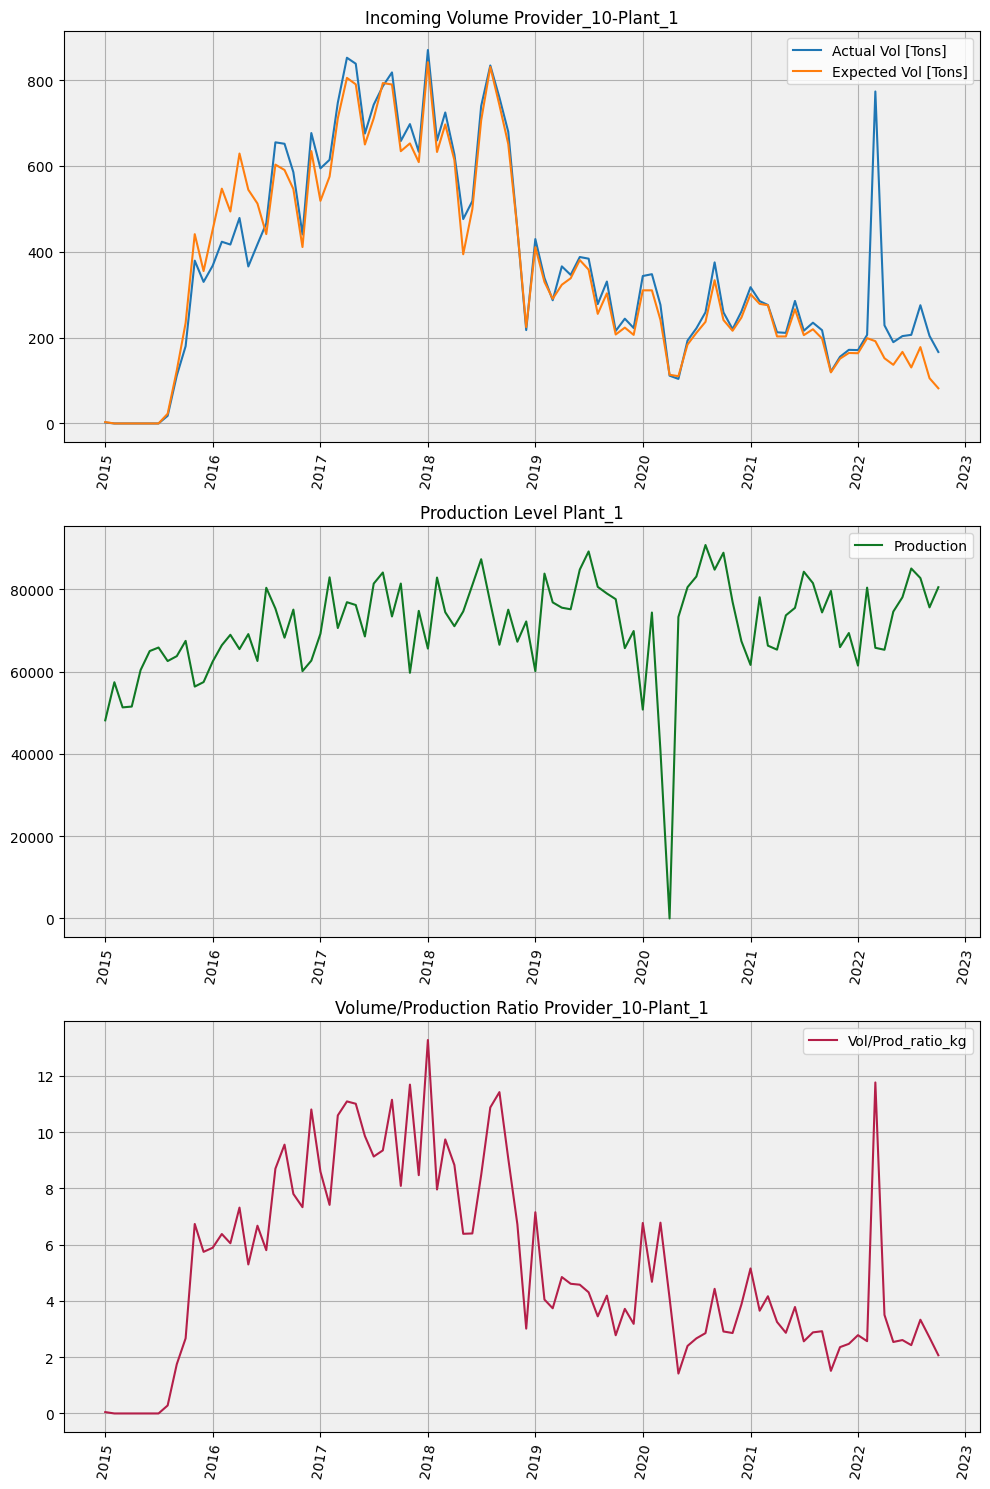

In [191]:
# Task1: Code Here
ts_key = 'Provider_10-Plant_1'
plant = ts_key.split('-')[1]
x_axis = 'Timestamp'
vol1_axis = 'Actual Vol [Tons]'
vol2_axis = 'Expected Vol [Tons]'
prod_axis = 'Production'
ratio_axis = 'Vol/Prod_ratio_kg'

_df = ts.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
vol1 = _df[vol1_axis]
vol2 = _df[vol2_axis]
prod = _df[prod_axis]
ratio = _df[ratio_axis]

# Create a figure
plt.rc('text',usetex=False)
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

line_colors = {vol1_axis: '#1f76b4', 
               vol2_axis: '#ff7e0e', 
               prod_axis: '#107824', 
               ratio_axis: '#b41f49',
               'background_color': '#f0f0f0',
               }

# Create Volume Plot
axs[0].plot(x, vol1, label=vol1_axis, color=line_colors[vol1_axis])
axs[0].plot(x, vol2, label=vol2_axis, color=line_colors[vol2_axis])  
axs[0].set_title(f'Incoming Volume {ts_key}')
axs[0].legend()
axs[0].tick_params(axis='x', rotation=80)
axs[0].set_facecolor(line_colors['background_color']) 
axs[0].grid(True)

# Production Plot
axs[1].plot(x, prod, label=prod_axis, color=line_colors[prod_axis])
axs[1].set_title(f'Production Level {plant}')
axs[1].tick_params(axis='x', rotation=80)
axs[1].legend()
axs[1].set_facecolor(line_colors['background_color']) 
axs[1].grid(True)

# Ratio Plot
axs[2].plot(x, ratio, label=ratio_axis, color=line_colors[ratio_axis])
axs[2].set_title(f'Volume/Production Ratio {ts_key}')
axs[2].tick_params(axis='x', rotation=80)
axs[2].legend()
axs[2].set_facecolor(line_colors['background_color']) 
axs[2].grid(True)

# Add labels and adjust layout
plt.tight_layout()
plt.show()

In [53]:
# Task2: Code Here
with PdfPages('Timeseries_Vol_Prod_Ratio.pdf') as pdf:
    
    x_axis = 'Timestamp'
    vol1_axis = 'Actual Vol [Tons]'
    vol2_axis = 'Expected Vol [Tons]'
    prod_axis = 'Production'
    ratio_axis = 'Vol/Prod_ratio_kg'
    light_gray = '#f0f0f0'
    
    line_colors = {vol1_axis: '#1f76b4', 
                    vol2_axis: '#ff7e0e', 
                    prod_axis: '#107824', 
                    ratio_axis: '#b41f49',
                    }

    for ts_key in tqdm(ts['ts_key'].unique()[:10]):
            
        _df = ts.query(f" ts_key == '{ts_key}'")
        x = _df[x_axis]
        vol1 = _df[vol1_axis]
        vol2 = _df[vol2_axis]
        prod = _df[prod_axis]
        ratio = _df[ratio_axis]

        # Create a figure
        plt.rc('text',usetex=False)
        fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

        # Create Volume Plot
        axs[0].plot(x, vol1, label=vol1_axis, color=line_colors[vol1_axis])
        axs[0].plot(x, vol2, label=vol2_axis, color=line_colors[vol2_axis])  
        axs[0].set_title(f'Incoming Volume {ts_key}')
        axs[0].legend()
        axs[0].tick_params(axis='x', rotation=80)
        axs[0].set_facecolor(light_gray) 
        axs[0].grid(True)

        # Production Plot
        axs[1].plot(x, prod, label=prod_axis, color=line_colors[prod_axis])
        axs[1].set_title(f'Production Level {plant}')
        axs[1].tick_params(axis='x', rotation=80)
        axs[1].legend()
        axs[1].set_facecolor(light_gray) 
        axs[1].grid(True)

        # Ratio Plot
        axs[2].plot(x, ratio, label=ratio_axis, color=line_colors[ratio_axis])
        axs[2].set_title(f'Volume/Production Ratio {ts_key}')
        axs[2].tick_params(axis='x', rotation=80)
        axs[2].legend()
        axs[2].set_facecolor(light_gray) 
        axs[2].grid(True)

        # Add labels and adjust layout
        plt.tight_layout()
            
        # saves the current figure into a pdf page
        pdf.savefig(fig) 
        plt.close(fig)
        
        del _df

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Timeseries Vol-Prod-Ratio'
    d['Author'] = 'John Torres'
    d['CreationDate'] = datetime.today()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


# 3. Time Series Analysis

Let's Analyse the timeseries for using the `Vol/Prod_ratio_ton`. Which will be our target variable. 

## 3.1 Linear Interpolation

In [205]:
# Let's reset all indeces to have a monolitic increasing
# index for all timeseries. This is a prerequisite for 
# the interpolation 
ts.reset_index(drop= True)

In [212]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
0,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144,2344.0,3109.0,0.00005,0.04869,94
1,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400,0.0,0.0,0.00000,0.00000,94
2,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290,0.0,0.0,0.00000,0.00000,94
3,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489,0.0,0.0,0.00000,0.00000,94
4,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348,0.0,0.0,0.00000,0.00000,94


In [208]:
# Solve it in One line
ts['Vol/Prod_ratio_kg'] = ts['Vol/Prod_ratio_kg'].interpolate(method='polynomial', order=1)

In [209]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
0,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144,2344.0,3109.0,0.00005,0.04869,94
1,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400,0.0,0.0,0.00000,0.00000,94
2,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290,0.0,0.0,0.00000,0.00000,94
3,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489,0.0,0.0,0.00000,0.00000,94
4,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348,0.0,0.0,0.00000,0.00000,94


In [157]:
# First let's linearly interpolate all the
# missing value for the Covid Outbreak in April 2020
ts_key = "Provider_10-Plant_1"
_df = ts[ts["ts_key"] == ts_key][["Timestamp", "Vol/Prod_ratio_kg"]].reset_index(
    drop=True
)
y = _df[~_df["Vol/Prod_ratio_kg"].isna()]["Vol/Prod_ratio_kg"].values
x = _df[~_df["Vol/Prod_ratio_kg"].isna()].index.values
xvals = _df[_df["Vol/Prod_ratio_kg"].isna()].index.values
yinterp = np.interp(xvals, x, y)

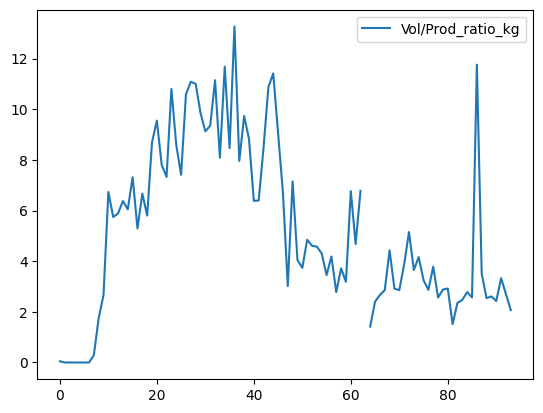

In [158]:
_df.plot(y=["Vol/Prod_ratio_kg"])
plt.show()

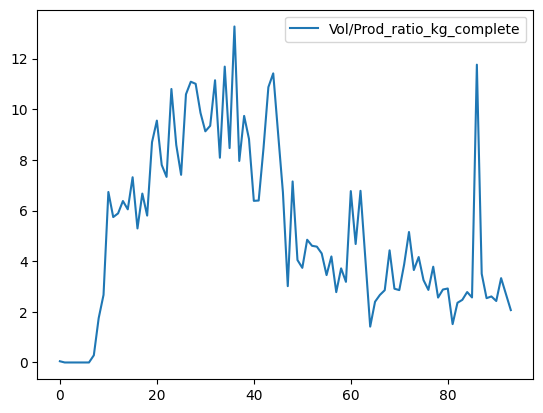

In [159]:
_df["Vol/Prod_ratio_kg_complete"] = np.where(
    _df["Vol/Prod_ratio_kg"].isna(), yinterp[0], _df["Vol/Prod_ratio_kg"]
)
_df.plot(y=["Vol/Prod_ratio_kg_complete"])
plt.show()

In [211]:
ts.head()

,Timestamp,ts_key,Actual Vol [Tons],Expected Vol [Tons],Plant,Production,Actual Vol [Kg],Expected Vol [Kg],Vol/Prod_ratio_ton,Vol/Prod_ratio_kg,ts_len
0,2015-01-01,Provider_10-Plant_1,2.344,3.109,Plant_1,48144,2344.0,3109.0,0.00005,0.04869,94
1,2015-02-01,Provider_10-Plant_1,0.000,0.000,Plant_1,57400,0.0,0.0,0.00000,0.00000,94
2,2015-03-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51290,0.0,0.0,0.00000,0.00000,94
3,2015-04-01,Provider_10-Plant_1,0.000,0.000,Plant_1,51489,0.0,0.0,0.00000,0.00000,94
4,2015-05-01,Provider_10-Plant_1,0.000,0.000,Plant_1,60348,0.0,0.0,0.00000,0.00000,94


In [160]:
# Generate Interpolation for all timeseries
# First let's linearly interpolate all the
# missing value for the Covid Outbreak in April 2020
ts_key = "Provider_10-Plant_1"
col_to_interp = "Vol/Prod_ratio_kg"
col_to_interp_idx = list(ts.columns).index(col_to_interp)
for ts_key in ts['ts_key'].unique():
    
    _df = ts[ts["ts_key"] == ts_key][["Timestamp", col_to_interp]].copy()
    y = _df[~_df[col_to_interp].isna()][col_to_interp].values
    x = _df[~_df[col_to_interp].isna()].index.values
    xvals = _df[_df[col_to_interp].isna()].index.values
    yinterp = np.interp(xvals, x, y)
    
    # Replace all missing values in their correpondings
    # position, if there are any
    if len(yinterp) > 0:
        for index, value in zip(xvals, yinterp):
                print("ts_key: ", ts_key)
                print("index:", index, "value:", value)
                ts.iat[index, col_to_interp_idx] = value
    print()

ts_key:  Provider_10-Plant_1
index: 63 value: 4.097795

ts_key:  Provider_10-Plant_10
index: 169 value: 71.8246

ts_key:  Provider_10-Plant_11
index: 275 value: 12.614795

ts_key:  Provider_10-Plant_12
index: 381 value: 0.36780999999999997

ts_key:  Provider_10-Plant_13
index: 487 value: 9.607025

ts_key:  Provider_10-Plant_14
index: 593 value: 4.081315

ts_key:  Provider_10-Plant_15
index: 699 value: 13.985430000000001

ts_key:  Provider_10-Plant_18
index: 805 value: 20.381495

ts_key:  Provider_10-Plant_19
index: 911 value: 13.996775

ts_key:  Provider_10-Plant_20
index: 1017 value: 2.93547

ts_key:  Provider_10-Plant_4
index: 1123 value: 0.47870500000000005

ts_key:  Provider_10-Plant_5
index: 1214 value: 27.88463

ts_key:  Provider_14-Plant_1
index: 1301 value: 5.85112

ts_key:  Provider_14-Plant_10
index: 1407 value: 12.421945000000001

ts_key:  Provider_14-Plant_11
index: 1513 value: 7.126645

ts_key:  Provider_14-Plant_12
index: 1619 value: 1.2151349999999999

ts_key:  Provider_

# 3.2 Time Series Analysis 

Ref: https://www.kaggle.com/code/konradb/ts-0-the-basics

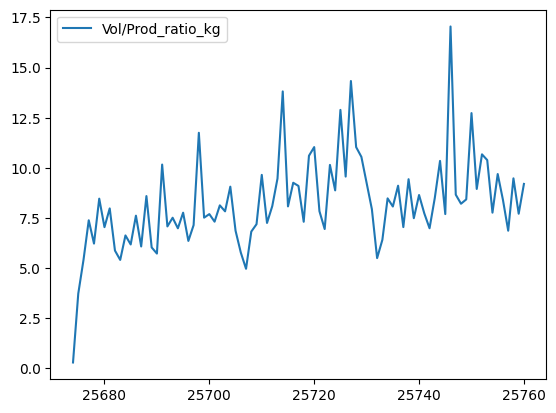

In [210]:
ts_key = "Provider_9-Plant_5"
ts[ts["ts_key"] == ts_key].plot(y=[col_to_interp])
plt.show()

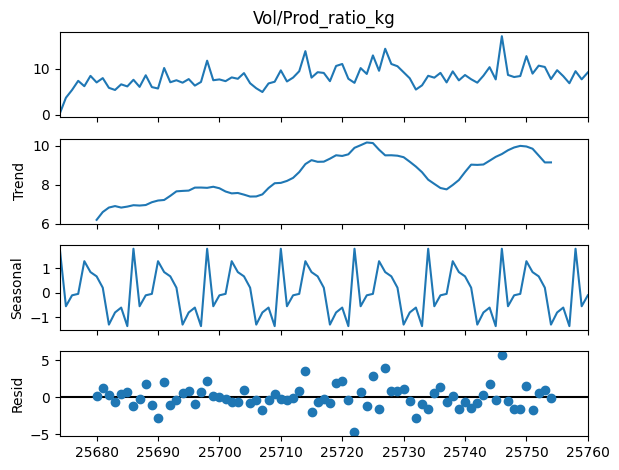

In [168]:
decomposition = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key][col_to_interp],period =12) 
figure = decomposition.plot()
plt.show()

In [178]:
decomposition = sm.tsa.seasonal_decompose(ts[ts["ts_key"] == ts_key][col_to_interp], period =12) 

In [186]:
len(decomposition.seasonal)

87

In [190]:
trend = pd.DataFrame({'trend': decomposition.trend, 
                      'sesonality': decomposition.seasonal,
                      'residuals': decomposition.resid})
trend[~trend['trend'].isna()].shape

(75, 3)

# Feature Engineering

Ref: https://github.com/john2408/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter06/01-Feature%20Engineering.ipynb

# Feature Engineering Analysis - Feature Selection

Ref: https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

